In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/swapniel99/erav1s8.git
%cd erav1s8/
!git checkout develop
!git pull
%ls

fatal: destination path 'erav1s8' already exists and is not an empty directory.
/content/erav1s8
Already on 'develop'
Your branch is up to date with 'origin/develop'.
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 4), reused 6 (delta 3), pack-reused 0
Unpacking objects: 100% (7/7), 719 bytes | 719.00 KiB/s, done.
From https://github.com/swapniel99/erav1s8
   51495e1..99b1540  develop    -> origin/develop
   d75e29d..c4eea7c  main       -> origin/main
Updating 51495e1..99b1540
Fast-forward
 datasets/generic.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)
backprop.py  ghostbn.py  __pycache__/  requirements.txt  utils.py
datasets/    model.py    README.md     S8.ipynb


In [3]:
from utils import *
set_seed(42)

Device Selected: cuda


In [4]:
from datasets import CIFAR10
batch_size = 32
cifar10 = CIFAR10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


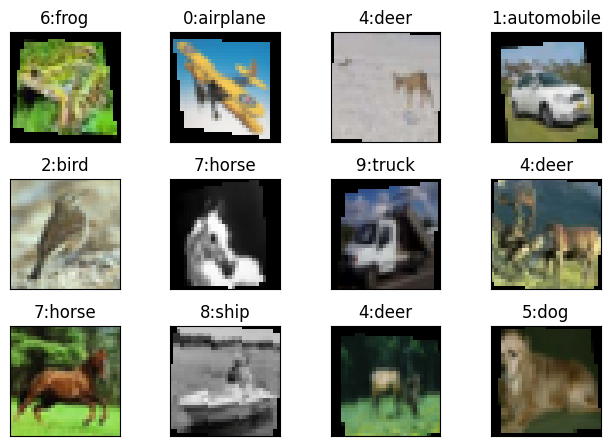

In [5]:
cifar10.show_examples()

In [6]:
from model import GroupNormModel, LayerNormModel, BatchNormModel
from backprop import Experiment

# Experiment 1: Group Normalisation

In [9]:
model1 = GroupNormModel(n_groups=4, skip=True, dropout=0.01)
model1.summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
GroupNormModel                           [32, 3, 32, 32]           [32, 10]                  --                             --
├─Sequential: 1-1                        [32, 3, 32, 32]           [32, 16, 28, 28]          --                             --
│    └─ConvLayer: 2-1                    [32, 3, 32, 32]           [32, 16, 30, 30]          --                             --
│    │    └─Conv2d: 3-1                  [32, 3, 32, 32]           [32, 16, 30, 30]          432                         0.90%
│    │    └─GroupNorm: 3-2               [32, 16, 30, 30]          [32, 16, 30, 30]          32                          0.07%
│    │    └─ReLU: 3-3                    [32, 16, 30, 30]          [32, 16, 30, 30]          --                             --
│    │    └─Dropout: 3-4                 [32, 16, 30, 30]          [32, 16, 30, 30]          --                

In [10]:
exp1 = Experiment(model1, cifar10, lr=0.01)
exp1.execute()

Epoch 1


Train: Batch_id=1562, Average Loss=1.8403, Accuracy=31.05: 100%|██████████| 1563/1563 [00:46<00:00, 33.52it/s]


Test: Average loss: 1.6130, Accuracy: 39.96
Epoch 2


Train: Batch_id=1562, Average Loss=1.5175, Accuracy=44.05: 100%|██████████| 1563/1563 [00:47<00:00, 33.22it/s]


Test: Average loss: 1.3547, Accuracy: 49.89
Epoch 3


Train: Batch_id=1562, Average Loss=1.3633, Accuracy=50.14: 100%|██████████| 1563/1563 [00:46<00:00, 33.58it/s]


Test: Average loss: 1.2611, Accuracy: 53.37
Epoch 4


Train: Batch_id=1562, Average Loss=1.2561, Accuracy=54.35: 100%|██████████| 1563/1563 [00:46<00:00, 33.45it/s]


Test: Average loss: 1.1693, Accuracy: 57.19
Epoch 5


Train: Batch_id=1562, Average Loss=1.1801, Accuracy=57.54: 100%|██████████| 1563/1563 [00:46<00:00, 33.45it/s]


Test: Average loss: 1.1215, Accuracy: 58.00
Epoch 6


Train: Batch_id=1562, Average Loss=1.1172, Accuracy=60.04: 100%|██████████| 1563/1563 [00:46<00:00, 33.46it/s]


Test: Average loss: 1.0517, Accuracy: 62.12
Epoch 7


Train: Batch_id=1562, Average Loss=1.0666, Accuracy=61.50: 100%|██████████| 1563/1563 [00:46<00:00, 33.45it/s]


Test: Average loss: 0.9795, Accuracy: 64.69
Epoch 8


Train: Batch_id=1562, Average Loss=1.0256, Accuracy=63.31: 100%|██████████| 1563/1563 [00:46<00:00, 33.38it/s]


Test: Average loss: 0.9733, Accuracy: 65.16
Epoch 9


Train: Batch_id=1562, Average Loss=0.9916, Accuracy=64.73: 100%|██████████| 1563/1563 [00:47<00:00, 33.02it/s]


Test: Average loss: 0.9647, Accuracy: 65.62
Epoch 10


Train: Batch_id=1562, Average Loss=0.9547, Accuracy=66.06: 100%|██████████| 1563/1563 [00:48<00:00, 32.37it/s]


Test: Average loss: 0.8640, Accuracy: 69.23
Epoch 11


Train: Batch_id=1562, Average Loss=0.9323, Accuracy=67.14: 100%|██████████| 1563/1563 [00:48<00:00, 32.52it/s]


Test: Average loss: 0.8554, Accuracy: 69.45
Epoch 12


Train: Batch_id=1562, Average Loss=0.9083, Accuracy=67.87: 100%|██████████| 1563/1563 [00:48<00:00, 32.29it/s]


Test: Average loss: 0.8090, Accuracy: 71.39
Epoch 13


Train: Batch_id=1562, Average Loss=0.8869, Accuracy=68.78: 100%|██████████| 1563/1563 [00:48<00:00, 32.25it/s]


Test: Average loss: 0.8038, Accuracy: 71.66
Epoch 14


Train: Batch_id=1562, Average Loss=0.8659, Accuracy=69.44: 100%|██████████| 1563/1563 [00:48<00:00, 32.45it/s]


Test: Average loss: 0.8537, Accuracy: 70.08
Epoch 00014: reducing learning rate of group 0 to 3.0000e-03.
Epoch 15


Train: Batch_id=1562, Average Loss=0.7820, Accuracy=72.50: 100%|██████████| 1563/1563 [00:48<00:00, 32.35it/s]


Test: Average loss: 0.7255, Accuracy: 74.79
Epoch 16


Train: Batch_id=1562, Average Loss=0.7682, Accuracy=72.92: 100%|██████████| 1563/1563 [00:47<00:00, 32.60it/s]


Test: Average loss: 0.7271, Accuracy: 74.72
Epoch 00016: reducing learning rate of group 0 to 9.0000e-04.
Epoch 17


Train: Batch_id=1562, Average Loss=0.7345, Accuracy=74.04: 100%|██████████| 1563/1563 [00:48<00:00, 32.41it/s]


Test: Average loss: 0.6871, Accuracy: 76.22
Epoch 18


Train: Batch_id=1562, Average Loss=0.7314, Accuracy=74.20: 100%|██████████| 1563/1563 [00:48<00:00, 32.55it/s]


Test: Average loss: 0.6804, Accuracy: 76.43
Epoch 19


Train: Batch_id=1562, Average Loss=0.7222, Accuracy=74.60: 100%|██████████| 1563/1563 [00:47<00:00, 32.74it/s]


Test: Average loss: 0.6858, Accuracy: 76.38
Epoch 00019: reducing learning rate of group 0 to 2.7000e-04.
Epoch 20


Train: Batch_id=1562, Average Loss=0.7149, Accuracy=74.95: 100%|██████████| 1563/1563 [00:48<00:00, 32.52it/s]


Test: Average loss: 0.6735, Accuracy: 76.85


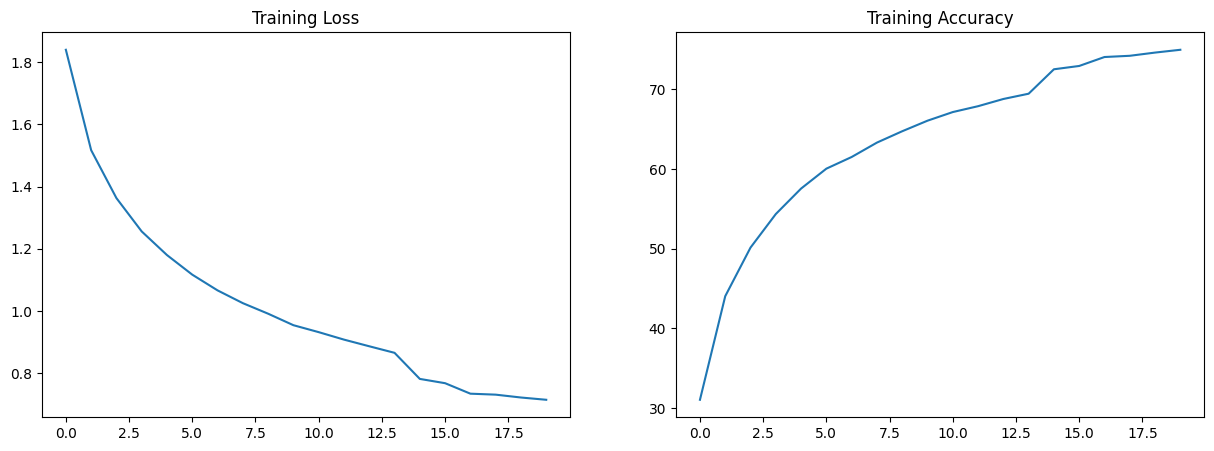

In [11]:
exp1.train.plot_stats()

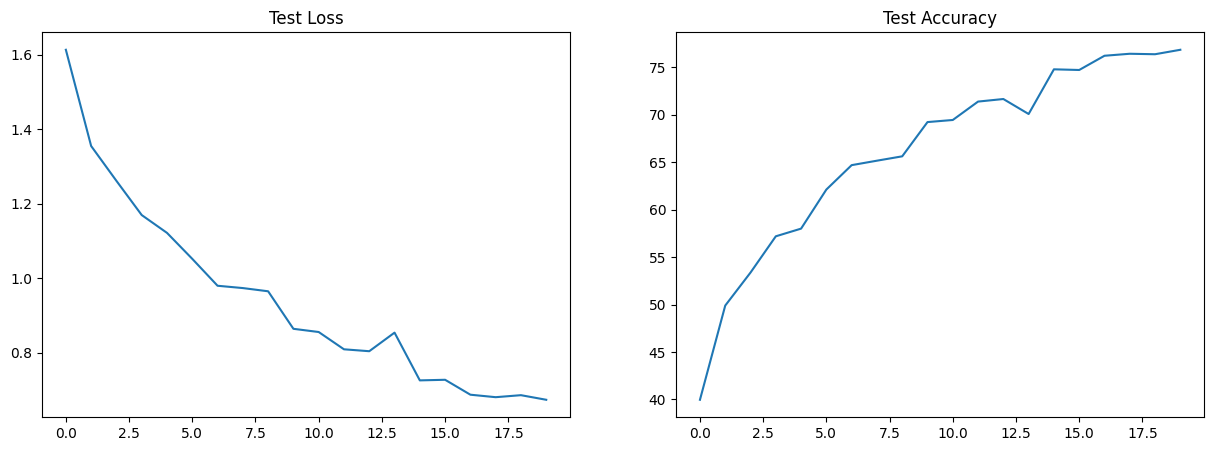

In [12]:
exp1.test.plot_stats()

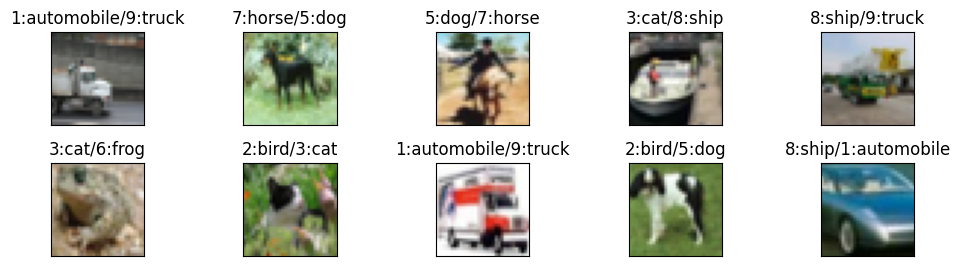

In [13]:
exp1.test.show_incorrect()

# Experiment 2: Layer Normalisation

In [14]:
model2 = LayerNormModel(skip=True, dropout=0.01)
model2.summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
LayerNormModel                           [32, 3, 32, 32]           [32, 10]                  --                             --
├─Sequential: 1-1                        [32, 3, 32, 32]           [32, 16, 28, 28]          --                             --
│    └─ConvLayer: 2-1                    [32, 3, 32, 32]           [32, 16, 30, 30]          --                             --
│    │    └─Conv2d: 3-1                  [32, 3, 32, 32]           [32, 16, 30, 30]          432                         0.90%
│    │    └─GroupNorm: 3-2               [32, 16, 30, 30]          [32, 16, 30, 30]          32                          0.07%
│    │    └─ReLU: 3-3                    [32, 16, 30, 30]          [32, 16, 30, 30]          --                             --
│    │    └─Dropout: 3-4                 [32, 16, 30, 30]          [32, 16, 30, 30]          --                

In [15]:
exp2 = Experiment(model2, cifar10)
exp2.execute()

Epoch 1


Train: Batch_id=1562, Average Loss=1.8831, Accuracy=29.56: 100%|██████████| 1563/1563 [00:46<00:00, 33.38it/s]


Test: Average loss: 1.6180, Accuracy: 40.01
Epoch 2


Train: Batch_id=1562, Average Loss=1.6039, Accuracy=40.83: 100%|██████████| 1563/1563 [00:46<00:00, 33.26it/s]


Test: Average loss: 1.4648, Accuracy: 45.71
Epoch 3


Train: Batch_id=1562, Average Loss=1.4293, Accuracy=47.75: 100%|██████████| 1563/1563 [00:47<00:00, 32.84it/s]


Test: Average loss: 1.3130, Accuracy: 51.49
Epoch 4


Train: Batch_id=1562, Average Loss=1.2985, Accuracy=52.71: 100%|██████████| 1563/1563 [00:48<00:00, 32.40it/s]


Test: Average loss: 1.1260, Accuracy: 59.12
Epoch 5


Train: Batch_id=1562, Average Loss=1.2045, Accuracy=56.32: 100%|██████████| 1563/1563 [00:48<00:00, 32.10it/s]


Test: Average loss: 1.1079, Accuracy: 59.27
Epoch 6


Train: Batch_id=1562, Average Loss=1.1368, Accuracy=59.11: 100%|██████████| 1563/1563 [00:49<00:00, 31.88it/s]


Test: Average loss: 1.0387, Accuracy: 62.01
Epoch 7


Train: Batch_id=1562, Average Loss=1.0957, Accuracy=60.80: 100%|██████████| 1563/1563 [00:48<00:00, 32.21it/s]


Test: Average loss: 0.9656, Accuracy: 65.74
Epoch 8


Train: Batch_id=1562, Average Loss=1.0547, Accuracy=62.32: 100%|██████████| 1563/1563 [00:48<00:00, 32.16it/s]


Test: Average loss: 0.9527, Accuracy: 65.89
Epoch 9


Train: Batch_id=1562, Average Loss=1.0272, Accuracy=63.25: 100%|██████████| 1563/1563 [00:47<00:00, 32.59it/s]


Test: Average loss: 0.9520, Accuracy: 66.01
Epoch 10


Train: Batch_id=1562, Average Loss=0.9986, Accuracy=64.48: 100%|██████████| 1563/1563 [00:47<00:00, 32.80it/s]


Test: Average loss: 0.9746, Accuracy: 65.40
Epoch 00010: reducing learning rate of group 0 to 3.0000e-03.
Epoch 11


Train: Batch_id=1562, Average Loss=0.8985, Accuracy=67.98: 100%|██████████| 1563/1563 [00:47<00:00, 33.14it/s]


Test: Average loss: 0.8305, Accuracy: 70.45
Epoch 12


Train: Batch_id=1562, Average Loss=0.8785, Accuracy=68.96: 100%|██████████| 1563/1563 [00:47<00:00, 33.03it/s]


Test: Average loss: 0.8254, Accuracy: 70.40
Epoch 13


Train: Batch_id=1562, Average Loss=0.8701, Accuracy=69.20: 100%|██████████| 1563/1563 [00:47<00:00, 32.97it/s]


Test: Average loss: 0.8033, Accuracy: 71.33
Epoch 14


Train: Batch_id=1562, Average Loss=0.8592, Accuracy=69.58: 100%|██████████| 1563/1563 [00:47<00:00, 32.92it/s]


Test: Average loss: 0.8078, Accuracy: 70.81
Epoch 00014: reducing learning rate of group 0 to 9.0000e-04.
Epoch 15


Train: Batch_id=1562, Average Loss=0.8200, Accuracy=70.91: 100%|██████████| 1563/1563 [00:47<00:00, 32.92it/s]


Test: Average loss: 0.7617, Accuracy: 73.08
Epoch 16


Train: Batch_id=1562, Average Loss=0.8130, Accuracy=71.14: 100%|██████████| 1563/1563 [00:46<00:00, 33.33it/s]


Test: Average loss: 0.7504, Accuracy: 73.23
Epoch 17


Train: Batch_id=1562, Average Loss=0.8079, Accuracy=71.41: 100%|██████████| 1563/1563 [00:47<00:00, 33.01it/s]


Test: Average loss: 0.7486, Accuracy: 73.22
Epoch 18


Train: Batch_id=1562, Average Loss=0.8030, Accuracy=71.60: 100%|██████████| 1563/1563 [00:47<00:00, 33.08it/s]


Test: Average loss: 0.7545, Accuracy: 72.99
Epoch 00018: reducing learning rate of group 0 to 2.7000e-04.
Epoch 19


Train: Batch_id=1562, Average Loss=0.7866, Accuracy=72.14: 100%|██████████| 1563/1563 [00:47<00:00, 32.82it/s]


Test: Average loss: 0.7366, Accuracy: 73.94
Epoch 20


Train: Batch_id=1562, Average Loss=0.7880, Accuracy=72.19: 100%|██████████| 1563/1563 [00:47<00:00, 33.03it/s]


Test: Average loss: 0.7354, Accuracy: 73.92


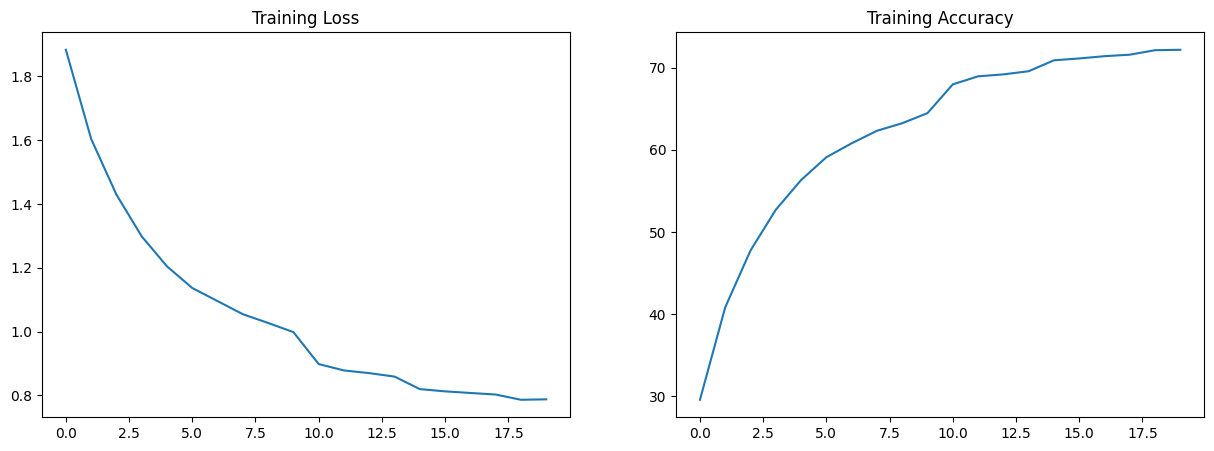

In [16]:
exp2.train.plot_stats()

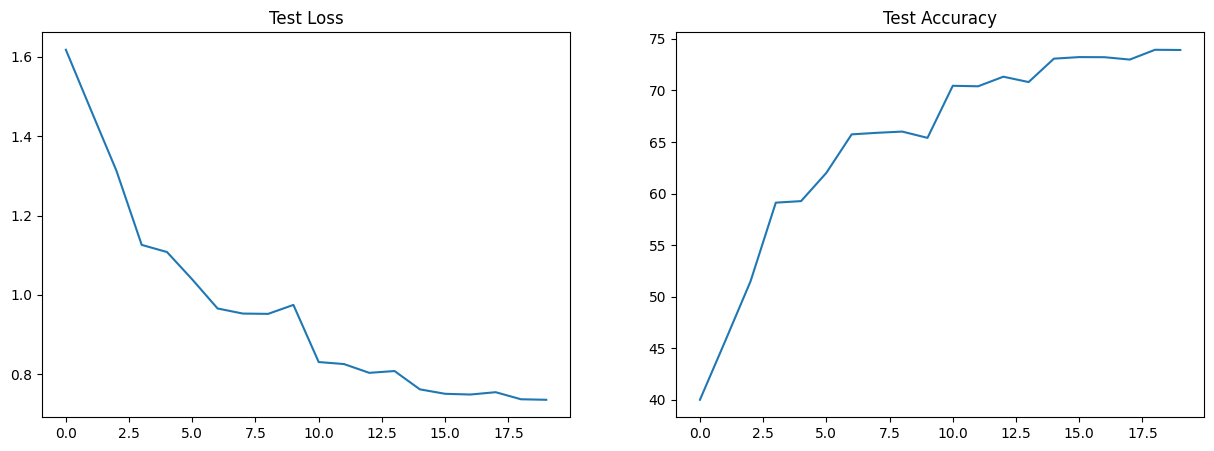

In [17]:
exp2.test.plot_stats()

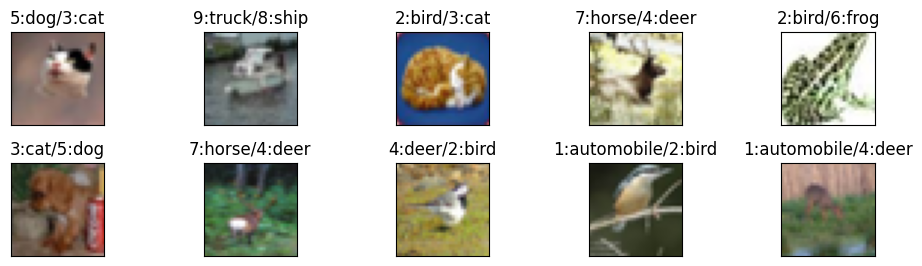

In [18]:
exp2.test.show_incorrect()

# Experiment 3: Batch Normalisation

In [19]:
model3 = BatchNormModel(skip=True, dropout=0.01)
model3.summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
BatchNormModel                           [32, 3, 32, 32]           [32, 10]                  --                             --
├─Sequential: 1-1                        [32, 3, 32, 32]           [32, 16, 28, 28]          --                             --
│    └─ConvLayer: 2-1                    [32, 3, 32, 32]           [32, 16, 30, 30]          --                             --
│    │    └─Conv2d: 3-1                  [32, 3, 32, 32]           [32, 16, 30, 30]          432                         0.90%
│    │    └─BatchNorm2d: 3-2             [32, 16, 30, 30]          [32, 16, 30, 30]          32                          0.07%
│    │    └─ReLU: 3-3                    [32, 16, 30, 30]          [32, 16, 30, 30]          --                             --
│    │    └─Dropout: 3-4                 [32, 16, 30, 30]          [32, 16, 30, 30]          --                

In [20]:
exp3 = Experiment(model3, cifar10)
exp3.execute()

Epoch 1


Train: Batch_id=1562, Average Loss=1.5501, Accuracy=42.71: 100%|██████████| 1563/1563 [00:47<00:00, 33.07it/s]


Test: Average loss: 1.2368, Accuracy: 55.23
Epoch 2


Train: Batch_id=1562, Average Loss=1.2369, Accuracy=55.41: 100%|██████████| 1563/1563 [00:44<00:00, 34.92it/s]


Test: Average loss: 1.0911, Accuracy: 60.55
Epoch 3


Train: Batch_id=1562, Average Loss=1.1212, Accuracy=60.01: 100%|██████████| 1563/1563 [00:44<00:00, 35.02it/s]


Test: Average loss: 0.9823, Accuracy: 64.37
Epoch 4


Train: Batch_id=1562, Average Loss=1.0546, Accuracy=62.39: 100%|██████████| 1563/1563 [00:44<00:00, 34.96it/s]


Test: Average loss: 0.9544, Accuracy: 66.04
Epoch 5


Train: Batch_id=1562, Average Loss=1.0039, Accuracy=64.30: 100%|██████████| 1563/1563 [00:46<00:00, 33.72it/s]


Test: Average loss: 0.9552, Accuracy: 65.12
Epoch 00005: reducing learning rate of group 0 to 3.0000e-03.
Epoch 6


Train: Batch_id=1562, Average Loss=0.8991, Accuracy=68.10: 100%|██████████| 1563/1563 [00:46<00:00, 33.36it/s]


Test: Average loss: 0.7926, Accuracy: 71.51
Epoch 7


Train: Batch_id=1562, Average Loss=0.8740, Accuracy=69.25: 100%|██████████| 1563/1563 [00:47<00:00, 32.95it/s]


Test: Average loss: 0.7768, Accuracy: 71.98
Epoch 8


Train: Batch_id=1562, Average Loss=0.8545, Accuracy=69.82: 100%|██████████| 1563/1563 [00:46<00:00, 33.87it/s]


Test: Average loss: 0.7551, Accuracy: 72.96
Epoch 9


Train: Batch_id=1562, Average Loss=0.8440, Accuracy=70.27: 100%|██████████| 1563/1563 [00:45<00:00, 34.59it/s]


Test: Average loss: 0.7401, Accuracy: 73.53
Epoch 10


Train: Batch_id=1562, Average Loss=0.8318, Accuracy=70.53: 100%|██████████| 1563/1563 [00:46<00:00, 33.89it/s]


Test: Average loss: 0.7312, Accuracy: 73.71
Epoch 11


Train: Batch_id=1562, Average Loss=0.8206, Accuracy=71.12: 100%|██████████| 1563/1563 [00:45<00:00, 34.55it/s]


Test: Average loss: 0.7178, Accuracy: 74.28
Epoch 12


Train: Batch_id=1562, Average Loss=0.8105, Accuracy=71.58: 100%|██████████| 1563/1563 [00:46<00:00, 33.85it/s]


Test: Average loss: 0.7183, Accuracy: 74.65
Epoch 00012: reducing learning rate of group 0 to 9.0000e-04.
Epoch 13


Train: Batch_id=1562, Average Loss=0.7766, Accuracy=72.75: 100%|██████████| 1563/1563 [00:46<00:00, 33.68it/s]


Test: Average loss: 0.6743, Accuracy: 75.94
Epoch 14


Train: Batch_id=1562, Average Loss=0.7612, Accuracy=73.45: 100%|██████████| 1563/1563 [00:46<00:00, 33.44it/s]


Test: Average loss: 0.6671, Accuracy: 76.48
Epoch 15


Train: Batch_id=1562, Average Loss=0.7568, Accuracy=73.24: 100%|██████████| 1563/1563 [00:47<00:00, 33.17it/s]


Test: Average loss: 0.6701, Accuracy: 76.13
Epoch 00015: reducing learning rate of group 0 to 2.7000e-04.
Epoch 16


Train: Batch_id=1562, Average Loss=0.7480, Accuracy=73.81: 100%|██████████| 1563/1563 [00:47<00:00, 32.97it/s]


Test: Average loss: 0.6588, Accuracy: 76.68
Epoch 17


Train: Batch_id=1562, Average Loss=0.7426, Accuracy=74.16: 100%|██████████| 1563/1563 [00:47<00:00, 32.64it/s]


Test: Average loss: 0.6625, Accuracy: 76.55
Epoch 00017: reducing learning rate of group 0 to 8.1000e-05.
Epoch 18


Train: Batch_id=1562, Average Loss=0.7442, Accuracy=73.90: 100%|██████████| 1563/1563 [00:47<00:00, 33.18it/s]


Test: Average loss: 0.6592, Accuracy: 76.34
Epoch 00018: reducing learning rate of group 0 to 2.4300e-05.
Epoch 19


Train: Batch_id=1562, Average Loss=0.7354, Accuracy=74.17: 100%|██████████| 1563/1563 [00:46<00:00, 33.27it/s]


Test: Average loss: 0.6531, Accuracy: 76.67
Epoch 20


Train: Batch_id=1562, Average Loss=0.7358, Accuracy=74.29: 100%|██████████| 1563/1563 [00:46<00:00, 33.64it/s]


Test: Average loss: 0.6524, Accuracy: 76.68


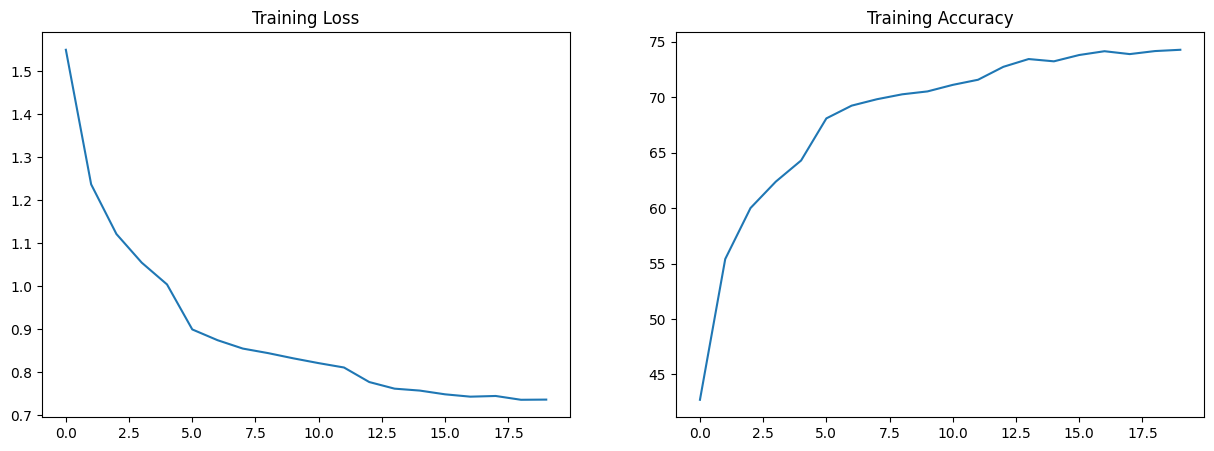

In [21]:
exp3.train.plot_stats()

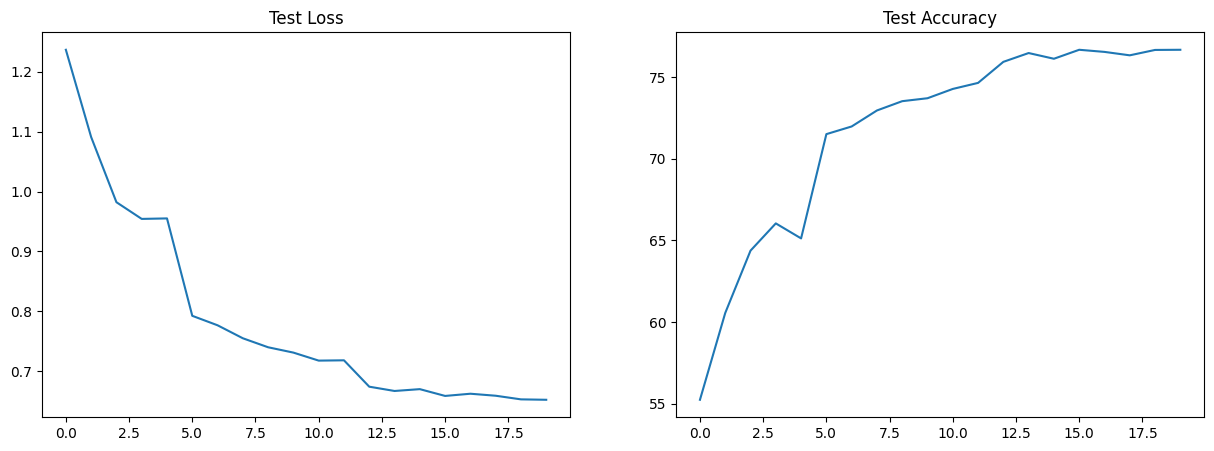

In [22]:
exp3.test.plot_stats()

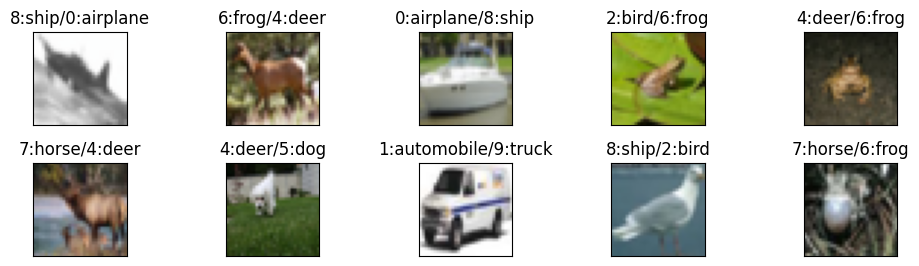

In [23]:
exp3.test.show_incorrect()